### this file is used to dave the results of all the models used which will be helpfull for validation

In [ ]:
#import necessary libraires
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
#  File paths
data_path = "../2PREPROCESSING/Processed_CSV/cropped_train.csv"
ml_dir = "CrossValidation/ML"
dl_dir = "CrossValidation/DL"

#  Ensure directories exist
os.makedirs(ml_dir, exist_ok=True)
os.makedirs(dl_dir, exist_ok=True)

df = pd.read_csv(data_path)
y = df.iloc[:, 0].values.astype(int)  # Labels (first column)
X = df.iloc[:, 1:].values  # Features (remaining columns)

#  Reshape for DL models (28x28 images)
X_dl = X.reshape(-1, 20, 20, 1).astype("float32")

#  Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# =========================
#  MACHINE LEARNING MODELS
# =========================
ml_models = {
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC()
}
ml_results = {}

for name, model in ml_models.items():
    print(f"\n Cross-validating {name}...")
    accuracies = []
    for train_idx, val_idx in cv.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        acc = accuracy_score(y[val_idx], y_pred)
        accuracies.append(acc)
    
    accuracies = np.array(accuracies)
    ml_results[name] = accuracies
    np.save(os.path.join(ml_dir, f"{name}_cross_val_results.npy"), accuracies)


🔍 Cross-validating KNN...

🔍 Cross-validating LogisticRegression...

🔍 Cross-validating NaiveBayes...

🔍 Cross-validating RandomForest...

🔍 Cross-validating SVM...


In [ ]:
# =======================
#  DEEP LEARNING MODELS
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  CNN (PyTorch)
class CNN_PyTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  #  Ensures contiguous memory
        x = self.relu(self.fc1(x))
        return self.fc2(x)

cnn_pytorch = CNN_PyTorch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_pytorch.parameters(), lr=0.001)

print("\n Cross-validating CNN (PyTorch)...")
cnn_pytorch_accs = []
for train_idx, val_idx in cv.split(X_dl, y):
    X_train_cv = torch.tensor(X_dl[train_idx], dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    y_train_cv = torch.tensor(y[train_idx], dtype=torch.long).to(device)
    X_val_cv = torch.tensor(X_dl[val_idx], dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    y_val_cv = torch.tensor(y[val_idx], dtype=torch.long).to(device)

    for epoch in range(3):
        optimizer.zero_grad()
        outputs = cnn_pytorch(X_train_cv)
        loss = criterion(outputs, y_train_cv)
        loss.backward()
        optimizer.step()
    
    y_pred = cnn_pytorch(X_val_cv).argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y[val_idx], y_pred)
    cnn_pytorch_accs.append(acc)

cnn_pytorch_accs = np.array(cnn_pytorch_accs)
np.save(os.path.join(dl_dir, "CNN_PyTorch_cross_val_results.npy"), cnn_pytorch_accs)

#  CNN (TensorFlow)
print("\n Cross-validating CNN (TF)...")
cnn_tf = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(20, 20, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

cnn_tf.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn_tf_accs = []
for train_idx, val_idx in cv.split(X_dl, y):
    cnn_tf.fit(X_dl[train_idx], y[train_idx], epochs=3, verbose=0)
    acc = cnn_tf.evaluate(X_dl[val_idx], y[val_idx], verbose=0)[1]
    cnn_tf_accs.append(acc)

np.save(os.path.join(dl_dir, "CNN_TF_cross_val_results.npy"), np.array(cnn_tf_accs))

#  Dense NN (TensorFlow)
print("\n Cross-validating DenseNN (TF)...")
dense_nn_tf = keras.Sequential([
    layers.Flatten(input_shape=(20, 20, 1)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

dense_nn_tf.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
dense_nn_tf_accs = []
for train_idx, val_idx in cv.split(X_dl, y):
    dense_nn_tf.fit(X_dl[train_idx], y[train_idx], epochs=3, verbose=0)
    acc = dense_nn_tf.evaluate(X_dl[val_idx], y[val_idx], verbose=0)[1]
    dense_nn_tf_accs.append(acc)

np.save(os.path.join(dl_dir, "DenseNN_TF_cross_val_results.npy"), np.array(dense_nn_tf_accs))


🔍 Cross-validating CNN (PyTorch)...

🔍 Cross-validating CNN (TF)...


c:\Users\RONIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Cross-validating DenseNN (TF)...


c:\Users\RONIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


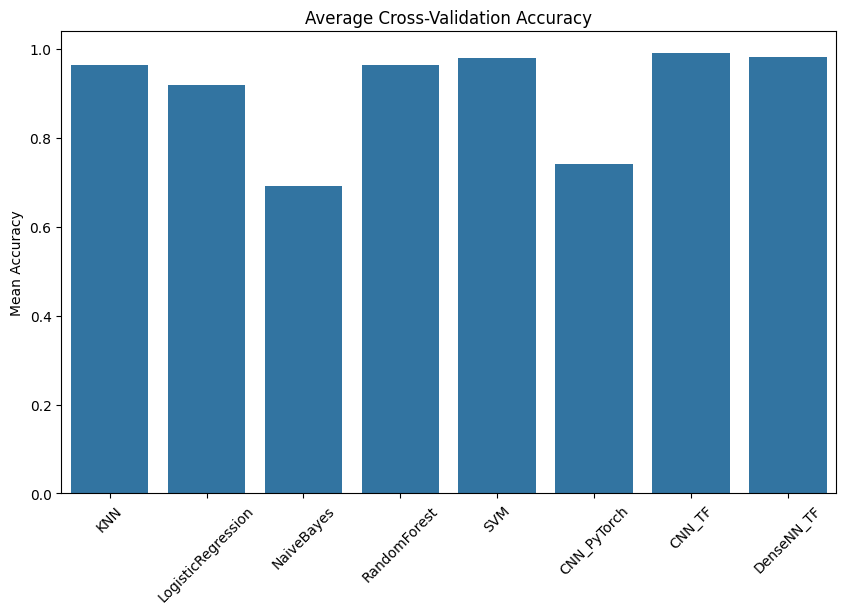

In [ ]:
#  Bar plot (Mean Accuracies)
plt.figure(figsize=(10, 6))
mean_accuracies = {name: np.mean(accs) for name, accs in all_results.items()}
sns.barplot(x=list(mean_accuracies.keys()), y=list(mean_accuracies.values()))
plt.title("Average Cross-Validation Accuracy")
plt.ylabel("Mean Accuracy")
plt.xticks(rotation=45)
plt.show()